
# Scikit-learn Naive Bayes binary classifier - Determining informative features

This notebook has been created to explore how to determine the most important features when using a Naive Bayes classifier on text documents. It is inspired by attempting to implement the 20 Newsgroups example for deriving important features, which fails when using a binary class.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import re as re
import operator

import sklearn
import sklearn.metrics as metrics

from tabulate import tabulate
from pprint import pprint
from collections import Counter

from __future__ import print_function

np.random.seed(0)

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
def DataFrameData (data):
    # Data and target as a data frame, with word count attributes
    Data   = pd.DataFrame(data.data)
    Target = pd.DataFrame(data.target)
    Frames  = [Data, Target]   
    DF = pd.concat(Frames, axis = 1) 
    DF.columns = ['Data', 'Target']
    DF['DataLength'] = DF.Data.apply(len)
    DF['WordCount'] = DF.Data.apply(lambda x: re.split("[ \[\]\\n\@\-\"!?:,.()<>]+", x)).apply(len)
    
    DF['WordsCounts'] = DF.Data.apply(lambda x: Counter(filter(None, re.split("[ \[\]\\n\@\-\"!?:,.()<>]+", x))))    
    
    DF['UniqueWords'] = DF['WordsCounts'].apply(len)
    DF['DataIndex'] = DF.index
    DF = DF[['Data', 'Target', 'DataLength', 'WordCount', 'UniqueWords', 'DataIndex', 'WordsCounts']]
    
    return DF

# The 20 NewsGroups dataset

The [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset) is used to explore the behaviour of coefficients and probabilties associated with Naive Bayes classifers when dealing with only 2 classes. 

The description of the dataset on Scikit Learn web site:


The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

This module contains two loaders. The first one, sklearn.datasets.fetch_20newsgroups, returns a list of the raw texts that can be fed to [text feature extractors](http://scikit-learn.org/stable/modules/feature_extraction.html) such as sklearn.feature_extraction.text.CountVectorizer with custom parameters so as to extract feature vectors. The second one, sklearn.datasets.fetch_20newsgroups_vectorized, returns ready-to-use features, i.e., it is not necessary to use a feature extractor.

It is easy for a classifier to overfit on particular things that appear in the 20 Newsgroups data, such as newsgroup headers. Many classifiers achieve very high F-scores, but their results would not generalize to other documents that aren’t from this window of time.

See [Classification of text documents using sparse features](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html) for an excellent summary evaluation of classifiers working with this data.

## Set up and explore the data

Examine basic information about the data...

In [6]:
from sklearn.datasets import fetch_20newsgroups

alltraindata = fetch_20newsgroups(subset='train', categories=None)
alltestdata  = fetch_20newsgroups(subset='test', categories=None)

What is [fetch_20newsgroups](#fetch_20newsgroups)?

What type of data structure is returned?

In [7]:
alltraindata.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [8]:
alltraindata.description

'the 20 newsgroups by date dataset'

In [9]:
print(tabulate([['Training',"{:,}".format(len(alltraindata.filenames))],
                ['Testing', "{:,}".format(len(alltestdata.filenames))],
                ['Combined', "{:,}".format(len(alltraindata.filenames)+len(alltestdata.filenames))],
                ['Categories',len(alltraindata.target_names)]], 
               headers = ['Dataset','Count']))

Dataset     Count
----------  -------
Training    11,314
Testing     7,532
Combined    18,846
Categories  20


In [10]:
alltraindata.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [11]:
alltraindata.target

array([7, 4, 4, ..., 3, 1, 8])

In [12]:
pathstr = alltraindata.filenames[0].replace('rec.autos\\102994', '')

In [14]:
print('Row Target  Class Name                 File Name                        Sample')
for (x, t) in enumerate(alltraindata.target[:20]):
    print(str(x).ljust(5), 
          str(t).ljust(5), 
          alltraindata.target_names[t].ljust(26), 
          alltraindata.filenames[x].replace(pathstr, '').ljust(32),
          alltraindata.data[x].lstrip()[0:30])

Row Target  Class Name                 File Name                        Sample
0     7     rec.autos                  rec.autos\102994                 From: lerxst@wam.umd.edu (wher
1     4     comp.sys.mac.hardware      comp.sys.mac.hardware\51861      From: guykuo@carson.u.washingt
2     4     comp.sys.mac.hardware      comp.sys.mac.hardware\51879      From: twillis@ec.ecn.purdue.ed
3     1     comp.graphics              comp.graphics\38242              From: jgreen@amber (Joe Green)
4     14    sci.space                  sci.space\60880                  From: jcm@head-cfa.harvard.edu
5     16    talk.politics.guns         talk.politics.guns\54525         From: dfo@vttoulu.tko.vtt.fi (
6     13    sci.med                    sci.med\58080                    From: bmdelane@quads.uchicago.
7     3     comp.sys.ibm.pc.hardware   comp.sys.ibm.pc.hardware\60249   From: bgrubb@dante.nmsu.edu (G
8     2     comp.os.ms-windows.misc    comp.os.ms-windows.misc\10008    From: holmes7000@iscsvax.

In [15]:
alltraindata.filenames[3].replace(pathstr, ''), alltraindata.target[3], alltraindata.data[3]

('comp.graphics\\38242',
 1,
 'From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It\'s got this\n> quadrilateral fill command that requires just the four points.\n\nDo you have Weitek\'s address/phone number?  I\'d like to get some information\nabout this chip.\n\n--\nJoe Green\t\t\t\tHarris Corporation\njgreen@csd.harris.com\t\t\tComputer Systems Division\n"The only thing that really scares me is a person with no sense of humor."\n\t\t\t\t\t\t-- Jonathan Winters\n')

## Reporting significant words using coef_ in Multinomial Naive Bayes

To examine the most important features in a group of classes using the Multinomial Naive Bases class the recommended approach in the [20 Newsgroups dataset tutorial](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) is to use function **show_top10**

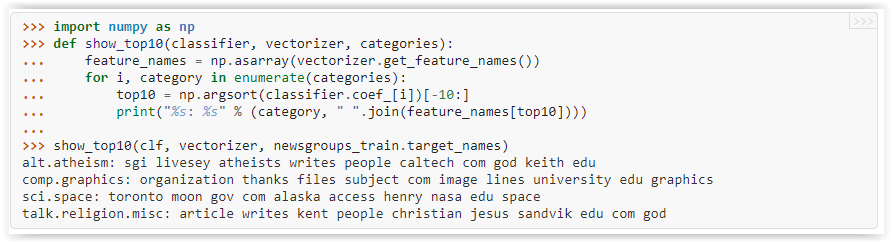

Following the recommended steps from the tutorial...

In [16]:
import numpy as np
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

Using the same newsgroups subset as the tutorial does, which also removes headers, footers and quotes...

In [17]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

traindat = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
testdat  = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

In [18]:
print(tabulate([['Training',"{:,}".format(len(traindat.filenames))],
                ['Testing', "{:,}".format(len(testdat.filenames))],
                ['Combined', "{:,}".format(len(traindat.filenames)+len(testdat.filenames))],
                ['Categories',len(traindat.target_names)]], 
               headers = ['Dataset','Count']))

Dataset     Count
----------  -------
Training    2,034
Testing     1,353
Combined    3,387
Categories  4


In [19]:
traindat.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectdat = TfidfVectorizer()

traindatvect = vectdat.fit_transform(traindat.data)
testdatvect = vectdat.transform(testdat.data)
traindatvect.shape, testdatvect.shape

((2034, 26879), (1353, 26879))

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

mnb = MultinomialNB(alpha=0.01)
mnb.fit(traindatvect, traindat.target)
pred = mnb.predict(testdatvect)
metrics.f1_score(testdat.target, pred, average='micro')

0.7908351810790836

In [22]:
report = metrics.classification_report(testdat.target, pred,
        target_names=testdat.target_names)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(testdat.target, pred)))

                    precision    recall  f1-score   support

       alt.atheism       0.68      0.68      0.68       319
     comp.graphics       0.92      0.89      0.91       389
         sci.space       0.81      0.90      0.85       394
talk.religion.misc       0.68      0.60      0.64       251

       avg / total       0.79      0.79      0.79      1353

accuracy: 0.791


In [23]:
show_top10(mnb, vectdat, traindat.target_names)

alt.atheism: not in and it you is that of to the
comp.graphics: graphics you in it is for of and to the
sci.space: for that it space is in and of to the
talk.religion.misc: not it in you is and that to of the


### The coef\_ properties:

- The words identified as most important don't seem to reflect what might be specifically most significant for the classes, rather just those that are most frequently used
- The results don't agree with the results quoted by the tutorial, which are:
```
alt.atheism: sgi livesey atheists writes people caltech com god keith edu
comp.graphics: organization thanks files subject com image lines university edu graphics
sci.space: toronto moon gov com alaska access henry nasa edu space
talk.religion.misc: article writes kent people christian jesus sandvik edu com god
```


## Issues with coef\_ in binary class Naive Bayes

### Using the top10 function with a Naive Bayes classifier trained on just two classes

This time reverting to the dataset with headers, footers and quotes - to enable a later comparison...

In [24]:
categ = ['alt.atheism', 'soc.religion.christian']

train0 = fetch_20newsgroups(subset='train', categories=categ)
test0  = fetch_20newsgroups(subset='test', categories=categ)

vect0 = TfidfVectorizer(lowercase=False)

train0vect = vect0.fit_transform(train0.data)
test0vect = vect0.transform(test0.data)

In [25]:
print(tabulate([['Training',"{:,}".format(len(train0.filenames))],
                ['Testing', "{:,}".format(len(test0.filenames))],
                ['Combined', "{:,}".format(len(train0.filenames)+len(test0.filenames))],
                ['Categories',len(train0.target_names)]], 
               headers = ['Dataset','Count']))

Dataset     Count
----------  -------
Training    1,079
Testing     717
Combined    1,796
Categories  2


In [26]:
train0.target_names

['alt.atheism', 'soc.religion.christian']

In [27]:
train0DF = DataFrameData(train0)

In [28]:
test0DF =  DataFrameData(test0)

In [29]:
train0DF.loc[20:40, :"UniqueWords"]

Data  Target  DataLength  \
20  From: jaeger@buphy.bu.edu (Gregg Jaeger)\nSubj...       0         684   
21  From: aa888@freenet.carleton.ca (Mark Baker)\n...       1        3976   
22  From: psb@matt.ksu.ksu.edu (Jr Phillip S Buckl...       1        8437   
23  From: whheydt@pbhya.pacbell.com (Wilson Heydt)...       1        1061   
24  From: Eugene.Bigelow@ebay.sun.com (Geno )\nSub...       1         572   
25  From: "Robert Knowles" <p00261@psilink.com>\nS...       0         745   
26  From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...       0        4092   
27  From: aidler@sol.uvic.ca (E Alan Idler)\nSubje...       1        3100   
28  From: aaronc@athena.mit.edu (Aaron Bryce Carde...       1        4954   
29  From: hayesstw@risc1.unisa.ac.za (Steve Hayes)...       1        2192   
30  From: jodfishe@silver.ucs.indiana.edu (joseph ...       1        2156   
31  From: keith@cco.caltech.edu (Keith Allan Schne...       0        2103   
32  From: aaronc@athena.mit.edu (Aaron Bryce Carde...       1        2398   
33  From: gchin@ssf.Eng.Sun.COM (Gary Chin)\nSubje...       1        1636   
34  From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...       0        2816   
35  From: acooper@mac.cc.macalstr.edu\nSubject: Re...       0        4272   
36  From: news@cbnewsk.att.com\nSubject: Re: What ...       1        1830   
37  From: jayne@mmalt.guild.org (Jayne Kulikauskas...       1        1322   
38  From: thssccb@iitmax.iit.edu (catherine c bare...       1        2098   
39  From: db7n+@andrew.cmu.edu (D. Andrew Byler)\n...       1        3580   
40  From: lmh@juliet.caltech.edu (Henling, Lawrenc...       0         964   

    WordCount  UniqueWords  
20        111           85  
21        666          288  
22       1391          650  
23        177          139  
24        104           86  
25        134          112  
26        717          347  
27        529          279  
28        893          404  
29        364          203  
30        352          221  
31        365          209  
32        430          241  
33        298          155  
34        477          257  
35        745          377  
36        314          187  
37        216          139  
38        325          225  
39        639          316  
40        149          111

In [30]:
DataLengths = train0DF.DataLength
DataLengths.mean(), DataLengths.std(), DataLengths.min(), DataLengths.max()

(2220.5301204819275, 2846.593071355274, 171, 51239)

In [31]:
clf0 = MultinomialNB(alpha=0.01)
clf0.fit(train0vect, train0.target)
pred = clf0.predict(test0vect)
metrics.f1_score(test0.target, pred, average='micro')

0.9539748953974896

In [32]:
report = metrics.classification_report(test0.target, pred,
        target_names=test0.target_names)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(test0.target, pred)))

                        precision    recall  f1-score   support

           alt.atheism       0.98      0.92      0.95       319
soc.religion.christian       0.94      0.98      0.96       398

           avg / total       0.96      0.95      0.95       717

accuracy: 0.954


This is overfitting the data because of features in the headers, footers, and quotes, as described in the tutorial...

Now apply **show_top10** to this binary dataset...

In [33]:
show_top10(clf0, vect0, train0.target_names)

alt.atheism: not you God in and is that to of the


IndexError: index 1 is out of bounds for axis 0 with size 1

### What's happened to coef_[1]?

show\_top10 printed `coef_[0]` but failed when printing `coef_[1]`. It looks as though the approach taken by show\_top10 is good for multiple classes, but that this two class MNB classifier either flattens the coef\_ into one row, or consists of only one coef\_ component.

Explore the coefficients...

In [34]:
clf0.coef_[0]

array([ -7.93939323, -10.59376169, -10.27472736, ..., -13.42632213,
       -13.42632213, -13.42632213])

In [35]:
clf0.coef_[1]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [36]:
print(len(clf0.coef_[0]))
print(clf0.coef_[0])

23035
[ -7.93939323 -10.59376169 -10.27472736 ... -13.42632213 -13.42632213
 -13.42632213]


In [37]:
print(len(clf0.feature_count_))
print(len(clf0.feature_count_[0]))
print(clf0.feature_count_)

2
23035
[[0.1087848  1.87580694 0.         ... 0.02991476 0.02453538 0.14758482]
 [2.40514352 0.15988904 0.2237331  ... 0.         0.         0.        ]]


Although the features count consists of 2 arrays, the coeficient is only 1, [as discussed here](https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c).  

### Explore the coef\_ relationship to features:

In [38]:
index = 0
coef_features_c1_c2 = []

for feat, c1, c2 in zip(vect0.get_feature_names(), clf0.feature_count_[0], clf0.feature_count_[1]):
    coef_features_c1_c2.append(tuple([clf0.coef_[0][index], feat, c1, c2]))
    index+=1

In [39]:
print("Feature Score       Feature    Class 1 Count      Class 2 Count")
print("--------------------------------------------------------------------")
for i in sorted(coef_features_c1_c2, reverse=True):
    print(i)

Feature Score       Feature    Class 1 Count      Class 2 Count
--------------------------------------------------------------------
(-4.322174442446721, 'the', 57.68338225805422, 89.91513598816599)
(-4.748450945225136, 'of', 38.01395564426039, 58.70533868230223)
(-4.763914151073268, 'to', 38.12404679940611, 57.804395004624986)
(-5.083234842295099, 'that', 30.077342469993287, 42.00039560123987)
(-5.091670422441673, 'is', 33.34702449502216, 41.647504057222946)
(-5.108763407772768, 'and', 24.336417209079144, 40.94150396531246)
(-5.29300239420194, 'in', 21.034332807650472, 34.050881308132226)
(-5.65417396849168, 'God', 7.651592275566746, 23.725646165026898)
(-5.665843261176825, 'you', 23.419141287333154, 23.450277764875697)
(-5.672213171162076, 'not', 16.30067020654374, 23.301312857506495)
(-5.677899440511654, 'it', 21.732026760124132, 23.169134610414325)
(-5.750428683701395, 'are', 14.856433475572027, 21.547488719423463)
(-5.759552144677373, 'be', 15.308852196656066, 21.35170428621906)
(

(-9.057093513848953, 'choosing', 0.033774228271168376, 0.7798268224960428)
(-9.058026221399544, 'Jerusalem', 0.030615023655995353, 0.7790904885005602)
(-9.059139329407778, 'lyrics', 0.0, 0.7782126342225426)
(-9.059370551509554, 'secular', 0.8199292178487311, 0.7780304031093532)
(-9.060598925834954, 'check', 0.3873485810726912, 0.7770630010820884)
(-9.061192093330583, 'beautiful', 0.45326598484893027, 0.7765962793286052)
(-9.0626770486536, 'joke', 0.4697155946919975, 0.7754290858261348)
(-9.063057509474648, 'Sciences', 0.09585667817731161, 0.7751303176696583)
(-9.063309478995173, 'purposes', 0.33048585558728427, 0.7749325136813002)
(-9.06456523923138, 'spreading', 0.050756752049648024, 0.7739474452768282)
(-9.06546537557505, 'Mr', 1.235186735394632, 0.7732421031894571)
(-9.065502614207851, 'points', 0.33688053887337793, 0.7732129368674422)
(-9.066053094990052, 'express', 0.0821972873630369, 0.7727819118437053)
(-9.066574058603655, '100', 0.442140559440231, 0.7723742171565184)
(-9.066773

(-10.008691181108945, '22102', 0.0, 0.29497080238515605)
(-10.009189577277827, 'resuming', 0.0, 0.29481884397651686)
(-10.010196668887168, 'code', 0.6506736224558886, 0.294512018003243)
(-10.010362300534977, 'Logos', 0.0, 0.2944615853526605)
(-10.010591553296948, 'sends', 0.005144641315751641, 0.2943917946934609)
(-10.010623465229141, 'worldview', 0.0, 0.29438208111813857)
(-10.01064103965438, 'conceived', 0.17653726984078894, 0.2943767318250153)
(-10.010678418993837, 'hast', 0.03633068830377413, 0.29436535463647096)
(-10.010853628229706, 'Stanley', 0.0, 0.294312031686733)
(-10.010865710702053, 'ST', 0.0, 0.29430835486723783)
(-10.010865710702053, 'PASSION', 0.0, 0.29430835486723783)
(-10.011330252441045, 'drt', 0.0, 0.29416702376451753)
(-10.011451826280375, 'Stats', 0.0, 0.29413004725937475)
(-10.011451826280375, 'NS', 0.0, 0.29413004725937475)
(-10.011451826280375, 'Dalhousie', 0.0, 0.29413004725937475)
(-10.011922457690345, 'operating', 0.11586596548077406, 0.29398694778261425)
(-1

(-10.649402067080981, 'shaken', 0.0, 0.1506945175598831)
(-10.649859708375523, 'candidates', 0.0, 0.15062099393784723)
(-10.650155971822088, 'limit', 0.2961241802987733, 0.15057341485691203)
(-10.650238077477745, 'unadulterated', 0.0, 0.15056023141262903)
(-10.650238077477745, 'tomas', 0.0, 0.15056023141262903)
(-10.650238077477745, 'tafikah', 0.0, 0.15056023141262903)
(-10.650238077477745, 'reaffirmation', 0.0, 0.15056023141262903)
(-10.650238077477745, 'apodaca', 0.0, 0.15056023141262903)
(-10.650238077477745, 'Faulkner', 0.0, 0.15056023141262903)
(-10.650238077477745, 'Blaspheme', 0.0, 0.15056023141262903)
(-10.650289551167187, 'Drew', 0.0, 0.15055196699784235)
(-10.650613225621987, 'paradox', 0.10635879299113929, 0.15050000883667566)
(-10.650832128186828, 'warm', 0.0897101809116839, 0.15046487881825002)
(-10.651116520279228, 'cooperate', 0.0, 0.15041925036409973)
(-10.651186061938917, 'Mankind', 0.0, 0.15040809493107132)
(-10.651526045370979, 'incident', 0.0828123662789983, 0.15035

(-11.05553882739342, 'Unit', 0.0, 0.09705774864721642)
(-11.05553882739342, 'Latrobe', 0.0, 0.09705774864721642)
(-11.05553882739342, 'Cluster', 0.0, 0.09705774864721642)
(-11.05553882739342, 'Bundoora', 0.0, 0.09705774864721642)
(-11.05553882739342, 'Au', 0.0, 0.09705774864721642)
(-11.05553882739342, '3225200', 0.0, 0.09705774864721642)
(-11.05553882739342, '14263', 0.0, 0.09705774864721642)
(-11.056061788701184, 'Iraq', 0.32274383204460955, 0.09700177622395909)
(-11.056327173482762, 'garbage', 0.35251186453742184, 0.09697338334863259)
(-11.056757738625597, 'disposed', 0.0, 0.09692733425283065)
(-11.056835785056478, 'mentally', 0.17245190605996097, 0.09691898928168055)
(-11.057009553562011, '1983', 0.0, 0.0969004117428423)
(-11.05718276051449, 'hubris', 0.0, 0.09688189745175374)
(-11.05718276051449, 'hires', 0.0, 0.09688189745175374)
(-11.05750173729477, 'hospital', 0.12646127483852482, 0.09684781004506915)
(-11.057528182002088, 'handed', 0.26709000311266007, 0.09684498452336504)
(-1

(-11.455354542734847, 'disasterously', 0.0, 0.0617761810319745)
(-11.455354542734847, 'browsing', 0.0, 0.0617761810319745)
(-11.455463327530392, 'Campos', 0.0, 0.061768373299484966)
(-11.455656018358166, 'marital', 0.5626097990639805, 0.06175454552451143)
(-11.455656018358166, 'casual', 0.47817443877562127, 0.06175454552451143)
(-11.45649450776839, 'appelation', 0.0, 0.06169440531494152)
(-11.456999835839142, '130', 0.07508256654834546, 0.06165818527169308)
(-11.457559947103753, 'daughters', 0.3020350884910103, 0.061618059953291344)
(-11.457801051829357, 'mutually', 0.160639257122888, 0.06160079458206287)
(-11.457929993017794, 'matt', 0.12501768765463647, 0.06159156288570223)
(-11.457975551578198, 'xxx', 0.0, 0.061588301351456105)
(-11.457975551578198, 'universalizing', 0.0, 0.061588301351456105)
(-11.457975551578198, 'nonuniversal', 0.0, 0.061588301351456105)
(-11.457975551578198, 'demonstable', 0.0, 0.061588301351456105)
(-11.45853269904869, 'quota', 0.0, 0.061548427219358534)
(-11.4

(-11.976362752040908, 'shoes', 0.009462792761969586, 0.03262941343361744)
(-11.976362752040908, 'indecision', 0.04991398739625027, 0.03262941343361744)
(-11.976839668736233, 'unsupported', 0.0, 0.03260908760188855)
(-11.976839668736233, 'ticism', 0.0, 0.03260908760188855)
(-11.976839668736233, 'supplants', 0.0, 0.03260908760188855)
(-11.976839668736233, 'strains', 0.0, 0.03260908760188855)
(-11.976839668736233, 'snorts', 0.0, 0.03260908760188855)
(-11.976839668736233, 'skep', 0.0, 0.03260908760188855)
(-11.976839668736233, 'plished', 0.0, 0.03260908760188855)
(-11.976839668736233, 'perseverance', 0.0, 0.03260908760188855)
(-11.976839668736233, 'persecutions', 0.0, 0.03260908760188855)
(-11.976839668736233, 'penultimate', 0.0, 0.03260908760188855)
(-11.976839668736233, 'noteworthy', 0.0, 0.03260908760188855)
(-11.976839668736233, 'knit', 0.0, 0.03260908760188855)
(-11.976839668736233, 'invalidate', 0.0, 0.03260908760188855)
(-11.976839668736233, 'ingests', 0.0, 0.03260908760188855)
(-11

(-13.42632213025518, 'rat', 0.09929607634717783, 0.0)
(-13.42632213025518, 'rare', 0.14114235292834348, 0.0)
(-13.42632213025518, 'rapists', 0.05383974819698913, 0.0)
(-13.42632213025518, 'rapist', 1.0446910072474678, 0.0)
(-13.42632213025518, 'raping', 0.03645769848758622, 0.0)
(-13.42632213025518, 'raondom', 0.02512790444304161, 0.0)
(-13.42632213025518, 'rant', 0.08914179463801554, 0.0)
(-13.42632213025518, 'ranks', 0.4340147863598167, 0.0)
(-13.42632213025518, 'rank', 0.05312984430209301, 0.0)
(-13.42632213025518, 'ranges', 0.024535382171863834, 0.0)
(-13.42632213025518, 'randomness', 0.010974688135861978, 0.0)
(-13.42632213025518, 'randomly', 0.010019977531864668, 0.0)
(-13.42632213025518, 'rampage', 0.005884057989815363, 0.0)
(-13.42632213025518, 'rammed', 0.07711398582780615, 0.0)
(-13.42632213025518, 'rambo', 0.09062506215164631, 0.0)
(-13.42632213025518, 'rallies', 0.03281370401921939, 0.0)
(-13.42632213025518, 'rainy', 0.39560485886818686, 0.0)
(-13.42632213025518, 'raining',

(-13.42632213025518, 'cmtan', 0.27795297997531715, 0.0)
(-13.42632213025518, 'cmhnet', 0.2605028076136775, 0.0)
(-13.42632213025518, 'cmcl2', 0.09367249355683945, 0.0)
(-13.42632213025518, 'clutter', 0.030753796974711894, 0.0)
(-13.42632213025518, 'clown', 0.11317003366582133, 0.0)
(-13.42632213025518, 'clothe', 0.13982583006557794, 0.0)
(-13.42632213025518, 'closeley', 0.0642250529880098, 0.0)
(-13.42632213025518, 'clones', 0.3128823222633536, 0.0)
(-13.42632213025518, 'clinicaly', 0.12908673728965542, 0.0)
(-13.42632213025518, 'climbed', 0.041925858966136195, 0.0)
(-13.42632213025518, 'climatologist', 0.07299471228936218, 0.0)
(-13.42632213025518, 'cleverer', 0.010974688135861978, 0.0)
(-13.42632213025518, 'clerical', 0.024535382171863834, 0.0)
(-13.42632213025518, 'clearing', 0.02980440527419576, 0.0)
(-13.42632213025518, 'cleared', 0.2049187764519816, 0.0)
(-13.42632213025518, 'cleans', 0.13805391075475587, 0.0)
(-13.42632213025518, 'cleaning', 0.033774683997934575, 0.0)
(-13.42632

(-13.42632213025518, 'Clayton', 0.0946842888637144, 0.0)
(-13.42632213025518, 'Clark', 0.7636147639741596, 0.0)
(-13.42632213025518, 'Clarendon', 0.024535382171863834, 0.0)
(-13.42632213025518, 'Clam', 0.09982109339677245, 0.0)
(-13.42632213025518, 'Cindy', 0.13166833383101695, 0.0)
(-13.42632213025518, 'Christologic', 0.005884057989815363, 0.0)
(-13.42632213025518, 'Christianic', 0.03645769848758622, 0.0)
(-13.42632213025518, 'Chrismas', 0.13243557137182277, 0.0)
(-13.42632213025518, 'Choweller', 0.12529056639293243, 0.0)
(-13.42632213025518, 'Chow', 0.030753796974711894, 0.0)
(-13.42632213025518, 'Chopping', 0.05383974819698913, 0.0)
(-13.42632213025518, 'Chomsky', 0.09367249355683945, 0.0)
(-13.42632213025518, 'Cho', 0.27287653443647514, 0.0)
(-13.42632213025518, 'Chittick', 0.0898296740109003, 0.0)
(-13.42632213025518, 'Chistmas', 0.06123179303366699, 0.0)
(-13.42632213025518, 'Chimps', 0.40609874256491024, 0.0)
(-13.42632213025518, 'Chimpanzees', 0.12893261123251482, 0.0)
(-13.426

The most frequently used words are at one end - potentially significant words like God, Jesus, Christians and believe; but also all of the commonly used words. Scarcely used words are at the other end - which are all given the same value, and are dominated by what looks like numbers and words in less frequently used _case_, especially upper case. 

There are also many words in the top group that are particular to the newsgroup headers - like From, Subject, Lines, In - and some that are probably header words that are very strongly indicative for one class e.g. (-6.706752448220122, 'rutgers', 0.0, 8.274609331431554), or for a particular time for one class e.g. (-6.887757960548998, 'Apr', 1.796503032741633, 6.902932852663163)

**The counts for the features in the 4th column are for the second class - soc.religion.christian** - and are all highest for it. This could indicate that the scores (1st column) which drive this are more important for that class, or it could just indicate that there are more words in that class (which is true). The idea that the score favors the Christian class is also evident in many of the words that are found high in the list are used - captilizing He is particularly Christian.

A search for information about problems with coef\_ in relation to sklearn Naive Bayes classifiers in binary classification mode reveals various approaches to working with the coef_ values: 

One suggestion is a compact [function](https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers) for visualizing the coefficients that overcomes the problem with the single coefficient. The authors have called show_most_informative_features (presumably a substitute for the built-in function of other sklearn classifiers), but more accurately should perhaps be named something like **show_most_frequent_words**:

### The most frequent words

In [40]:
def show_most_frequent_words_test(clf, vectorizer, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [41]:
show_most_frequent_words_test(clf0, vect0, n=30)

	-13.4263	000406         		-4.3222		the            
	-13.4263	001125         		-4.7485		of             
	-13.4263	0100           		-4.7639		to             
	-13.4263	010116         		-5.0832		that           
	-13.4263	011255         		-5.0917		is             
	-13.4263	012536         		-5.1088		and            
	-13.4263	013034         		-5.2930		in             
	-13.4263	013423TAN102   		-5.6542		God            
	-13.4263	013657         		-5.6658		you            
	-13.4263	015931         		-5.6722		not            
	-13.4263	0195           		-5.6779		it             
	-13.4263	01wb           		-5.7504		are            
	-13.4263	020504         		-5.7596		be             
	-13.4263	020701TAN102   		-5.8464		for            
	-13.4263	021635         		-5.8547		we             
	-13.4263	022621TAN102   		-5.8929		as             
	-13.4263	023044         		-5.8953		have           
	-13.4263	024150         		-5.9048		this           
	-13.4263	024626         		-5.9905		was            
	-13.4263	02

That worked. But as observed above, these are most likely the (top and bottom) feature / probability scores for the _second_ class, so this may not be fully useful yet - it should be showing scores for both classes.

Further searching reveals an interesting conversation that says that the data returned in `coef_` in the binary class situation is not representative of how other classifiers and multi-class NB behave, and suggests an approach using `feature_log_prob_` to correctly calculate coefficients...

See discussions here:

https://github.com/scikit-learn/scikit-learn/issues/7233  
https://github.com/scikit-learn/scikit-learn/issues/2237  
https://stackoverflow.com/questions/40789364/sklearn-how-to-find-out-which-features-are-responsible-for-predicted-label

In [42]:
from sklearn.naive_bayes import BaseDiscreteNB

From running ??BaseDiscreteNB the following definitions are found - and yes a different approach is taken if there are only 2 classes.

This confirms the obervation above, when a Naive Bayes binary class exists, the `coef_` contains the values of `feature_log_prob_` for the _second_ class only: `self.feature_log_prob_[1:]`,

Therefore experiment with using both halves of `feature_log_prob_` for observing the most frequent words per class, and additionally for a proper understanding of the relative word significance per class in relation to the other class.

In [43]:
type(clf0.feature_log_prob_), type(clf0.coef_)

(numpy.ndarray, numpy.ndarray)

In [44]:
len(clf0.feature_log_prob_), len(clf0.feature_log_prob_[0]), len(clf0.coef_), len(clf0.coef_[0])

(2, 23035, 1, 23035)

In [45]:
clf0.feature_log_prob_

array([[-10.7048823 ,  -7.9400847 , -13.1796107 , ..., -11.79544956,
        -11.94021143, -10.42223191],
       [ -7.93939323, -10.59376169, -10.27472736, ..., -13.42632213,
        -13.42632213, -13.42632213]])

In [46]:
clf0.coef_[0]

array([ -7.93939323, -10.59376169, -10.27472736, ..., -13.42632213,
       -13.42632213, -13.42632213])

In [47]:
clf0.feature_log_prob_[1,:]

array([ -7.93939323, -10.59376169, -10.27472736, ..., -13.42632213,
       -13.42632213, -13.42632213])

In [48]:
clf0.coef_[0] == clf0.feature_log_prob_[1,:]

array([ True,  True,  True, ...,  True,  True,  True])

`coef_[0]` is the same as `feature_log_prob_[1,:]`

`feature_log_prob_` consists of 2 lists, the first one is the "missing" coef\_[0]

In [49]:
clf0.feature_log_prob_[0,:]

array([-10.7048823 ,  -7.9400847 , -13.1796107 , ..., -11.79544956,
       -11.94021143, -10.42223191])

Try now to use `feature_log_prob` instead of `coef_`, and get the features for the **first class** (atheism) using `feature_log_prob_[0,:]`

In [50]:
index = 0
coef_features_c1_c2 = []

for feat, c1, c2 in zip(vect0.get_feature_names(), clf0.feature_count_[0], clf0.feature_count_[1]):
    coef_features_c1_c2.append(tuple([clf0.feature_log_prob_[0,:][index], feat, c1, c2]))
    index+=1

In [51]:
print("Feature Score       Feature    Class 1 Count      Class 2 Count")
print("--------------------------------------------------------------------")
for i in sorted(coef_features_c1_c2, reverse=True):
    print(i)

Feature Score       Feature    Class 1 Count      Class 2 Count
--------------------------------------------------------------------
(-4.519298041714983, 'the', 57.68338225805422, 89.91513598816599)
(-4.93333301653942, 'to', 38.12404679940611, 57.804395004624986)
(-4.936224143625145, 'of', 38.01395564426039, 58.70533868230223)
(-5.067172136698374, 'is', 33.34702449502216, 41.647504057222946)
(-5.17033594905048, 'that', 30.077342469993287, 42.00039560123987)
(-5.3820558149179005, 'and', 24.336417209079144, 40.94150396531246)
(-5.420459914703708, 'you', 23.419141287333154, 23.450277764875697)
(-5.495193411832322, 'it', 21.732026760124132, 23.169134610414325)
(-5.527809217825625, 'in', 21.034332807650472, 34.050881308132226)
(-5.54209888478535, 'edu', 20.73575467215091, 16.345544273532365)
(-5.782621008871731, 'not', 16.30067020654374, 23.301312857506495)
(-5.845356276800247, 'be', 15.308852196656066, 21.35170428621906)
(-5.875334631681366, 'are', 14.856433475572027, 21.547488719423463)
(

(-9.116682103940757, 'sequel', 0.5714434341402518, 0.05515536444540011)
(-9.117017790649934, 'discussing', 0.5712482840637497, 0.3718134180683964)
(-9.117538812852054, '51', 0.5709455196831388, 0.7890464090273611)
(-9.117838633237625, 'EVER', 0.5707713664820765, 0.0)
(-9.120482307394319, '48', 0.5692380239516166, 0.4584557910943977)
(-9.121716855655208, 'Hmm', 0.5685233678859754, 0.587807687936306)
(-9.121959423263794, 'Death', 0.5683830538746215, 0.04878828778763508)
(-9.123052281670347, 'Slavery', 0.5677513083590624, 0.0)
(-9.123164951794212, 'manner', 0.5676862167145966, 0.5733798007804084)
(-9.123194839166972, 'directly', 0.5676689514493077, 0.9519885892722328)
(-9.123368251637322, '3rd', 0.5675687851346871, 0.2285432053661673)
(-9.123867804431402, 'disagree', 0.5672803310893111, 1.1173881413478386)
(-9.124066108715986, 'school', 0.5671658652761546, 1.122047209012965)
(-9.125465742227217, 'short', 0.5663586096523704, 1.031386307424361)
(-9.12621709501173, 'weeks', 0.565925723651545

(-10.121945854898328, 'septuagint', 0.20277812167415954, 0.0)
(-10.121945854898328, 'masoretic', 0.20277812167415954, 0.0)
(-10.122293338387479, 'gravity', 0.20270419763446074, 0.016162627118611987)
(-10.122422853427164, 'Network', 0.2026766510257517, 0.8162870319151301)
(-10.122629326482071, 'east', 0.2026327435609171, 0.23530914070703582)
(-10.1226967984625, 'friendly', 0.20261839729259623, 0.06413214640747013)
(-10.122905604792592, 'SYR', 0.20257400586011445, 0.0)
(-10.122905604792592, 'SUVM', 0.20257400586011445, 0.0)
(-10.122905604792592, 'DRPORTER', 0.20257400586011445, 0.0)
(-10.123674020320491, 'invent', 0.20241072343559352, 0.24978928911307818)
(-10.124160593248313, 'usd', 0.2023073952683741, 0.0)
(-10.124160593248313, 'rfox', 0.2023073952683741, 0.0)
(-10.124160593248313, 'Dakota', 0.2023073952683741, 0.0)
(-10.124173296257874, 'Rights', 0.2023046983426315, 0.0)
(-10.124220845773783, 'fundamental', 0.20229460359700202, 1.1053662935543629)
(-10.124380441913885, 'leader', 0.202

(-10.585896589682571, 'hopper3', 0.12379371931076599, 0.0)
(-10.585896589682571, 'gargle', 0.12379371931076599, 0.0)
(-10.585896589682571, 'Sverdrup', 0.12379371931076599, 0.0)
(-10.585896589682571, 'Resaerch', 0.12379371931076599, 0.0)
(-10.585896589682571, '44135', 0.12379371931076599, 0.0)
(-10.585896589682571, '4019', 0.12379371931076599, 0.0)
(-10.585896589682571, '216', 0.12379371931076599, 0.0)
(-10.586587191890047, 'Him', 0.12370135297073395, 3.1487906249920043)
(-10.586893346060634, 'stolen', 0.12366042600920835, 0.43684300977492807)
(-10.587106005008833, 'prostitute', 0.1236320049457013, 0.11343435838152613)
(-10.587306422361017, 'Aztecs', 0.12360522545672988, 0.0)
(-10.587605914104344, 'psalm', 0.12356521778612263, 0.0)
(-10.588146418574105, 'supercede', 0.1234930446956009, 0.0)
(-10.588146418574105, 'bud', 0.1234930446956009, 0.0)
(-10.588146418574105, '734841689', 0.1234930446956009, 0.0)
(-10.588158113545214, 'Mahdi', 0.12349148350742883, 0.029445795161248765)
(-10.588615

(-11.116646688555296, 'infantile', 0.06869259872480711, 0.0)
(-11.116646688555296, 'evaluated', 0.06869259872480711, 0.0)
(-11.116646688555296, 'PDT', 0.06869259872480711, 0.0)
(-11.116646688555296, 'Neil', 0.06869259872480711, 0.0)
(-11.116646688555296, 'Bennett', 0.06869259872480711, 0.0)
(-11.116646688555296, 'Begin', 0.06869259872480711, 0.0)
(-11.116646688555296, '11847', 0.06869259872480711, 0.0)
(-11.116646688555296, '11826', 0.06869259872480711, 0.0)
(-11.116646688555296, '115670', 0.06869259872480711, 0.0)
(-11.11715809476809, 'Romans', 0.06865236512965038, 3.0407994252685153)
(-11.118073748512437, 'sects', 0.06858037975888437, 0.16318665521238315)
(-11.118666799809962, 'Univ', 0.06853379137872352, 1.1206166604616516)
(-11.118670077441136, 'resolving', 0.06853353397434253, 0.062257839981241986)
(-11.118844065007565, 'Scientist', 0.06851987130448506, 1.1108612187229112)
(-11.11917637877399, 'flag', 0.06849378240540285, 0.0)
(-11.12032641510722, 'fourth', 0.06840356359110472, 0.

(-11.917449773836617, '_want_', 0.025330479084799195, 0.0852860173405069)
(-11.91792168972283, 'involvement', 0.02531381000396295, 0.299883581968593)
(-11.91792168972283, 'foster', 0.02531381000396295, 0.3082991079175946)
(-11.91792168972283, 'March', 0.02531381000396295, 0.4675477865494285)
(-11.91792168972283, 'IL', 0.02531381000396295, 0.35424392002395316)
(-11.923199982393504, 'wand', 0.02512790444304161, 0.0)
(-11.923199982393504, 'slide', 0.02512790444304161, 0.0)
(-11.923199982393504, 'sheltering', 0.02512790444304161, 0.0)
(-11.923199982393504, 'separating', 0.02512790444304161, 0.0)
(-11.923199982393504, 'raondom', 0.02512790444304161, 0.0)
(-11.923199982393504, 'punishnment', 0.02512790444304161, 0.0)
(-11.923199982393504, 'probablity', 0.02512790444304161, 0.0)
(-11.923199982393504, 'numner', 0.02512790444304161, 0.0)
(-11.923199982393504, 'invalidating', 0.02512790444304161, 0.0)
(-11.923199982393504, 'inflicted', 0.02512790444304161, 0.0)
(-11.923199982393504, 'devise', 0.

(-13.179610702404709, 'tendencies', 0.0, 0.12649511159447072)
(-13.179610702404709, 'temptation', 0.0, 0.07993128760033993)
(-13.179610702404709, 'tempt', 0.0, 0.11044373884542229)
(-13.179610702404709, 'temporized', 0.0, 0.04636564267436434)
(-13.179610702404709, 'temporal', 0.0, 0.24000655707931196)
(-13.179610702404709, 'tempered', 0.0, 0.18916039624084927)
(-13.179610702404709, 'temperature', 0.0, 0.0405203528265599)
(-13.179610702404709, 'temper', 0.0, 1.0403850563450008)
(-13.179610702404709, 'tellabs', 0.0, 1.2140044357440372)
(-13.179610702404709, 'telerama', 0.0, 0.28725393212648953)
(-13.179610702404709, 'tel', 0.0, 0.17135762966600293)
(-13.179610702404709, 'tekel', 0.0, 0.0570927535593525)
(-13.179610702404709, 'tehy', 0.0, 0.12208399877502059)
(-13.179610702404709, 'teeth', 0.0, 0.6104643625482672)
(-13.179610702404709, 'teens', 0.0, 0.2533814322671039)
(-13.179610702404709, 'teenage', 0.0, 0.18870499197807306)
(-13.179610702404709, 'tedr', 0.0, 0.5637965605082713)
(-13.17

(-13.179610702404709, 'honors', 0.0, 0.07946674705392869)
(-13.179610702404709, 'honoring', 0.0, 0.3415398417928526)
(-13.179610702404709, 'honored', 0.0, 0.09981605080532086)
(-13.179610702404709, 'homoousios', 0.0, 0.018030622519412395)
(-13.179610702404709, 'homeland', 0.0, 0.10527270193282773)
(-13.179610702404709, 'holographs', 0.0, 0.07402032662397308)
(-13.179610702404709, 'holograph', 0.0, 0.03701016331198654)
(-13.179610702404709, 'holocaust', 0.0, 0.07093585899993436)
(-13.179610702404709, 'hollowed', 0.0, 0.052250072202028666)
(-13.179610702404709, 'holiness', 0.0, 0.24888679675615993)
(-13.179610702404709, 'holidays', 0.0, 0.05018398899928078)
(-13.179610702404709, 'hoh', 0.0, 0.2928935268877886)
(-13.179610702404709, 'hoever', 0.0, 0.06419125880795351)
(-13.179610702404709, 'hobby', 0.0, 0.07270961984972495)
(-13.179610702404709, 'hobbes', 0.0, 0.19685293980278118)
(-13.179610702404709, 'hoaxes', 0.0, 0.13196613413514702)
(-13.179610702404709, 'hmmmmmm', 0.0, 0.10308028940

(-13.179610702404709, 'UNIVERSITY', 0.0, 0.2696984390593153)
(-13.179610702404709, 'UNITY', 0.0, 0.11985500034501013)
(-13.179610702404709, 'UManitoba', 0.0, 0.1189332011110532)
(-13.179610702404709, 'UMIACS', 0.0, 0.15490906703898852)
(-13.179610702404709, 'UH', 0.0, 0.1934258476278578)
(-13.179610702404709, 'UCNS', 0.0, 0.22287164384682812)
(-13.179610702404709, 'UCLA', 0.0, 0.10207013163095557)
(-13.179610702404709, 'U2', 0.0, 0.09655468103362737)
(-13.179610702404709, 'Tzotzil', 0.0, 0.1682409131872915)
(-13.179610702404709, 'Tyndale', 0.0, 0.1258837529379489)
(-13.179610702404709, 'Ty', 0.0, 0.077754022029964)
(-13.179610702404709, 'Twelker', 0.0, 0.3524208891084082)
(-13.179610702404709, 'Tull', 0.0, 0.1588054008873136)
(-13.179610702404709, 'Tucker', 0.0, 0.22069230415009114)
(-13.179610702404709, 'Tsk', 0.0, 0.0984718638394015)
(-13.179610702404709, 'Truths', 0.0, 0.10191948878393554)
(-13.179610702404709, 'Truthes', 0.0, 0.1258837529379489)
(-13.179610702404709, 'Tru', 0.0, 0.

(-13.179610702404709, 'Colossians', 0.0, 0.3148391229121011)
(-13.179610702404709, 'Colorado', 0.0, 0.878904306329038)
(-13.179610702404709, 'Collosions', 0.0, 0.13328103027613009)
(-13.179610702404709, 'Collosians', 0.0, 0.11763783781185938)
(-13.179610702404709, 'Collins', 0.0, 0.16296514498477976)
(-13.179610702404709, 'Cola', 0.0, 0.05517937505066677)
(-13.179610702404709, 'Col', 0.0, 0.3271140909529419)
(-13.179610702404709, 'Cohen', 0.0, 0.10207013163095557)
(-13.179610702404709, 'Cogito', 0.0, 0.08118936248580758)
(-13.179610702404709, 'Coffey', 0.0, 0.15893349410785737)
(-13.179610702404709, 'Codexes', 0.0, 0.026790616422176294)
(-13.179610702404709, 'Codex', 0.0, 0.18774472171275824)
(-13.179610702404709, 'Coca', 0.0, 0.05517937505066677)
(-13.179610702404709, 'Co', 0.0, 0.19191300084708787)
(-13.179610702404709, 'Cluster', 0.0, 0.09705774864721642)
(-13.179610702404709, 'Cloak', 0.0, 0.12482436027351354)
(-13.179610702404709, 'Cliff', 0.0, 0.047363128589405605)
(-13.179610702

These are the words that are most significant for the first class, Atheism. There is a similar  frequency of common words and preponderance of header-related words as seen for the Christian class, but now the key words are not so centered on Christian interests - God is there but now in close relationship with atheism, morality, Islam and _think_.

Therefore redesign the most signficant words function to return the most signficant words per class, rather than the top and bottom ranges of just the second class. 

## Show most frequent words

In [52]:
def show_most_frequent_words(clf, vectorizer, n=20, targetnames=None, bottom=False):
    
    # For binary Naive Bayes classifier frequent words
    
    feature_names = vectorizer.get_feature_names()
    
    cls_1 = 'Class 1'
    cls_2 = 'Class 2'
    if targetnames is not None and len(targetnames) == 2:
        cls_1 = targetnames[0]
        cls_2 = targetnames[1] 
        
    coefs_with_fns_c1 = sorted(zip(clf.feature_log_prob_[0,:], clf.feature_count_[0], feature_names))
    coefs_with_fns_c2 = sorted(zip(clf.feature_log_prob_[1,:], clf.feature_count_[1], feature_names))
    
    if bottom == True:
        top = zip(coefs_with_fns_c1[:n], coefs_with_fns_c2[:n])
    else:    
        top = zip(coefs_with_fns_c1[:-(n + 1):-1], coefs_with_fns_c2[:-(n + 1):-1])

    print("\t"+(cls_1+48*" ")[:48] + cls_2)
    print("\tScore      Count    Feature\t\t\tScore      Count    Feature")
    print("\t---------------------------\t\t\t---------------------------")

    for (coef_1, cnt_1, fn_1), (coef_2, cnt_2, fn_2) in top:
        print("\t%.4f\t   %.0f\t    %-15s\t\t%.4f\t   %.0f\t    %-15s" % (coef_1, cnt_1, fn_1, coef_2, cnt_2, fn_2))

In [53]:
show_most_frequent_words(clf0, vect0, n=50, targetnames=train0.target_names) 

	alt.atheism                                     soc.religion.christian
	Score      Count    Feature			Score      Count    Feature
	---------------------------			---------------------------
	-4.5193	   58	    the            		-4.3222	   90	    the            
	-4.9333	   38	    to             		-4.7485	   59	    of             
	-4.9362	   38	    of             		-4.7639	   58	    to             
	-5.0672	   33	    is             		-5.0832	   42	    that           
	-5.1703	   30	    that           		-5.0917	   42	    is             
	-5.3821	   24	    and            		-5.1088	   41	    and            
	-5.4205	   23	    you            		-5.2930	   34	    in             
	-5.4952	   22	    it             		-5.6542	   24	    God            
	-5.5278	   21	    in             		-5.6658	   23	    you            
	-5.5421	   21	    edu            		-5.6722	   23	    not            
	-5.7826	   16	    not            		-5.6779	   23	    it             
	-5.8454	   15	    be             		-5.7

## Show top10 frequent words

Re-design the show_top10 function...

In [54]:
def show_top10_freq(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.feature_log_prob_[i,:])[:-(10+1):-1]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

In [55]:
show_top10_freq(clf0, vect0, train0.target_names)

alt.atheism: the to of is that and you it in edu
soc.religion.christian: the of to that is and in God you not


## Show most important words 

The frequent words are identified in relation to their usage within each class, but they do not measure the significance of words when classes are compared with one another, which is important for a classification effort. Further exploration of the use of `feature_log_prob_` indicates a way to accomplish this... 

From the discussion in [issues/7233](https://github.com/scikit-learn/scikit-learn/issues/7233)...  

Trying these ideas out...

In [56]:
clf0.feature_log_prob_[1:] - clf0.feature_log_prob_[:1], len(clf0.feature_log_prob_[1:] - clf0.feature_log_prob_[:1])

(array([[ 2.76548908, -2.65367699,  2.90488334, ..., -1.63087257,
         -1.4861107 , -3.00409022]]), 1)

Applying the example above results in an array of length 1 enclosing the required array...  

Correct syntax to get the required array - one of these:  
`(self.feature_log_prob_[1:] - self.feature_log_prob_[:1])[0]`  
`self.feature_log_prob_[1,:] - self.feature_log_prob_[0,:]`  

Either:

In [57]:
(clf0.feature_log_prob_[1:]-clf0.feature_log_prob_[:1])[0], len((clf0.feature_log_prob_[1:]-clf0.feature_log_prob_[:1])[0])

(array([ 2.76548908, -2.65367699,  2.90488334, ..., -1.63087257,
        -1.4861107 , -3.00409022]), 23035)

Or:

In [58]:
clf0.feature_log_prob_[1,:] - clf0.feature_log_prob_[0,:], len(clf0.feature_log_prob_[1,:] - clf0.feature_log_prob_[0,:])

(array([ 2.76548908, -2.65367699,  2.90488334, ..., -1.63087257,
        -1.4861107 , -3.00409022]), 23035)

***Examine first class (atheism) using the log probability calculation:***

In [59]:
feature_names = vect0.get_feature_names()

diff = (clf0.feature_log_prob_[1:] - clf0.feature_log_prob_[:1])[0]
name_diff = {}
for i in range(len(feature_names)):
    name_diff[feature_names[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1))
for i in range(20):
    print(names_diff_sorted[i])

('keith', -7.08605403229401)
('Keith', -7.0703196880138215)
('solntze', -6.809896220788719)
('wpd', -6.809896220788719)
('Schneider', -6.652034415238038)
('TEK', -6.628674200213554)
('cco', -6.6132574225175045)
('mathew', -6.582954935785072)
('ICO', -6.559033107718415)
('Allan', -6.537770912368112)
('livesey', -6.4779883859947684)
('Rushdie', -6.458082458660893)
('Livesey', -6.450824658810685)
('Gregg', -6.403902431625337)
('kmr4', -6.402384800668406)
('bobbe', -6.394751404417981)
('Beauchaine', -6.381608234269066)
('Benedikt', -6.343548414084941)
('osrhe', -6.3207692794446295)
('motto', -6.2747053314572305)


***Examine second class (christianity):***

In [60]:
diff = (clf0.feature_log_prob_[1:] - clf0.feature_log_prob_[:1])[0]
name_diff = {}
for i in range(len(feature_names)):
    name_diff[feature_names[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(20):
    print(names_diff_sorted[i])

('rutgers', 6.472858254184587)
('athos', 6.175003166672653)
('Georgia', 5.940704784574043)
('uga', 5.895612392513049)
('geneva', 5.784012832252619)
('clh', 5.767641652180374)
('Covington', 5.6421148302843305)
('Petch', 5.619449456756682)
('Athens', 5.579565456577837)
('ai', 5.5649255400815365)
('mcovingt', 5.5649255400815365)
('Grass', 5.534493852795756)
('Valley', 5.534493852795756)
('Kulikauskas', 5.50338519348983)
('Programs', 5.375066793631478)
('grace', 5.345562374178219)
('Chuck', 5.315836641948032)
('liturgy', 5.2229342487516766)
('gvg', 5.2210437697717875)
('gvg47', 5.2210437697717875)


These words differentiate the two classes much more clearly than just the most frequently found words, the words that are in common or that score closely do not appear here. Many of the words continue to be header or footer related - for example rutgers and uga, but these are ones which strongly distinguish one class from another. 

Implement a show_most_informative_features function that uses the understanding gained here:

In [61]:
def show_most_informative_features(clf, vectorizer, n=30, targetnames=None):
    
    # For binary Naive Bayes classifier important features
    import operator
    
    feature_names = vectorizer.get_feature_names()
    
    cls_1 = 'Class 1'
    cls_2 = 'Class 2'
    if targetnames is not None and len(targetnames) == 2:
        cls_1 = targetnames[0]
        cls_2 = targetnames[1] 
        
    feature_names = vectorizer.get_feature_names()
    diff = clf.feature_log_prob_[1,:] - clf.feature_log_prob_[0,:]
    name_diff = {}
    for i in range(len(feature_names)):
        name_diff[feature_names[i]] = diff[i]
    names_diff_class0 = sorted(name_diff.items(), key = operator.itemgetter(1))
    names_diff_class1 = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
    
    top = zip(names_diff_class0[:n], names_diff_class1[:n])

    print("\t"+(cls_1+40*" ")[:40] + cls_2)
    print("\tScore\t\tFeature\t\t\tScore\t\tFeature")
    print("\t---------------------------\t\t---------------------------")
    
    for (fn_1, coef_1), (fn_2, coef_2) in top:
        print("\t%.4f\t\t%-15s\t\t%.4f\t\t%-15s" % (coef_1, fn_1, coef_2, fn_2))    

In [62]:
show_most_informative_features(clf0, vect0, n=50, targetnames=train0.target_names)

	alt.atheism                             soc.religion.christian
	Score		Feature			Score		Feature
	---------------------------		---------------------------
	-7.0861		keith          		6.4729		rutgers        
	-7.0703		Keith          		6.1750		athos          
	-6.8099		solntze        		5.9407		Georgia        
	-6.8099		wpd            		5.8956		uga            
	-6.6520		Schneider      		5.7840		geneva         
	-6.6287		TEK            		5.7676		clh            
	-6.6133		cco            		5.6421		Covington      
	-6.5830		mathew         		5.6194		Petch          
	-6.5590		ICO            		5.5796		Athens         
	-6.5378		Allan          		5.5649		ai             
	-6.4780		livesey        		5.5649		mcovingt       
	-6.4581		Rushdie        		5.5345		Grass          
	-6.4508		Livesey        		5.5345		Valley         
	-6.4039		Gregg          		5.5034		Kulikauskas    
	-6.4024		kmr4           		5.3751		Programs       
	-6.3948		bobbe          		5.3456		grace          
	-6.3816		Beauchaine     		5.

Define a compact top10 important features function...

In [63]:
def show_top10_imp(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    
    for i, category in enumerate(categories):
        otherlp = np.empty_like(classifier.feature_log_prob_[0])
        for i2, categ2 in enumerate(categories):
            if i2 != i:
                otherlp += classifier.feature_log_prob_[i2,:]
                
        top10 = np.argsort(classifier.feature_log_prob_[i,:] - otherlp)[:-(10+1):-1]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

In [64]:
show_top10_imp(clf0, vect0, train0.target_names)

alt.atheism: keith Keith solntze wpd Schneider TEK cco mathew ICO Allan
soc.religion.christian: rutgers athos Georgia uga geneva clh Covington Petch Athens mcovingt


The original 4 newsgroup set from the tutorial...

In [65]:
show_top10_important(mnb, vectdat, traindat.target_names)

alt.atheism: ico bobbe bronx beauchaine freewill mom mozumder cobb rushdie theists
comp.graphics: 00 000 graphics windows format package gif vga screen pc
sci.space: lunar spacecraft rockets centaur ssto mars comet shafer advertising titan
talk.religion.misc: 00 000 jesus bible koresh christ kent morality fbi faith


How do these compare with the published important words for 4 newsgroups in the tutorial?

`alt.atheism: sgi livesey atheists writes people caltech com god keith edu
comp.graphics: organization thanks files subject com image lines university edu graphics
sci.space: toronto moon gov com alaska access henry nasa edu space
talk.religion.misc: article writes kent people christian jesus sandvik edu com god`

Look at examples of the placement of five of the most important features...

In [66]:
for i in enumerate(train0.target):
    # print(i)
    m = re.search('keith|cheers|rushdie|rutgers|clh|\.edu', train0.data[i[0]].lower())
    if m != None:
        print(i[0], " Christian" if i[1] == 1 else " Atheist" )
        print("--------------")
        print(train0.data[i[0]]
              .replace('Keith', '\033[30;43mKeith\033[m')
              .replace('keith', '\033[30;43mkeith\033[m')
              .replace('Cheers', '\033[30;44mkeith\033[m')
              .replace('Rushdie', '\033[44;33mRushdie\033[m ')
              .replace('rutgers', '\033[30;45mrutgers\033[m')
              .replace('clh', '\033[30;46mclh\033[m'))
        print()
        print("====================================================================================")
        print()
    

1  Atheist
--------------
From: marshall@csugrad.cs.vt.edu (Kevin Marshall)
Subject: Re: some thoughts.
Organization: Virginia Tech Computer Science Dept, Blacksburg, VA
Lines: 72
NNTP-Posting-Host: csugrad.cs.vt.edu
Keywords: Dan Bissell

bissda@saturn.wwc.edu (DAN LAWRENCE BISSELL) writes:

>	Some reasons why he wouldn't be a liar are as follows.  Who would 
>die for a lie?  Wouldn't people be able to tell if he was a liar?  People 
>gathered around him and kept doing it, many gathered from hearing or seeing 
>someone who was or had been healed.  Call me a fool, but I believe he did 
>heal people.  

Anyone who dies for a "cause" runs the risk of dying for a lie.  As for
people being able to tell if he was a liar, well, we've had grifters and
charlatans since the beginning of civilization.  If David Copperfield had
been the Messiah, I bet he could have found plenty of believers.  
Jesus was hardly the first to claim to be a faith healer, and he wasn't the
first to be "witnessed."  Wh

305  Atheist
--------------
From: keith@cco.caltech.edu (Keith Allan Schneider)
Subject: Re: Objective morality (was Re: <Political Atheists?)
Organization: California Institute of Technology, Pasadena
Lines: 74
NNTP-Posting-Host: punisher.caltech.edu

livesey@solntze.wpd.sgi.com (Jon Livesey) writes:

>I want to know how this omniscient being is going to perform
>the feat of "definitely" terming actions right or wrong.

If you were omniscient, you'd know who exactly did what, and with what
purpose in mind.  Then, with a particular goal in mind, you sould be
able to methodically judge whether or not this action was in accordance
with the general goal.

>>>I don't think you've show the existence of *any* objective moral system.
>>They exist, but in practice, they are difficult to perfectly emulate.
>>I mean, you understand the concept of an objective system, right?
>I thought you were explaining it to us.   I certainly don't
>understand what you are explaining.

In an objective system, 

695  Atheist
--------------
Subject: Re: Don't more innocents die without the death penalty?
From: lippard@skyblu.ccit.arizona.edu (James J. Lippard)
Distribution: world,local
Organization: University of Arizona
Nntp-Posting-Host: skyblu.ccit.arizona.edu
News-Software: VAX/VMS VNEWS 1.41    
Lines: 21

In article <chrisb.734068710@bAARNie>, chrisb@tafe.sa.edu.au (Chris BELL) writes...
>	killing is wrong
>	if you kill we will punish you
>	our punishment will be to kill you.
> 
>Seems to be lacking in consistency.

Not any more so than

      holding people against their will is wrong
      if you hold people against their will we will punish you
      our punishment will be to hold you against your will

Is there any punishment which isn't something which, if done by a private
person to another private person for no apparent reason, would lead to
punishment?  (Fines, I suppose.)

Jim Lippard              Lippard@CCIT.ARIZONA.EDU
Dept. of Philosophy      Lippard@ARIZVMS.BITNET
University

Where the words are coming from headers and footers then they should _not_ be considered to be reliable features, since things like email addresses or time stamps vary over time, whereas the kind of language used in discussions changes more slowly - a classifier trained on these words will be generalizable. The 20 Newsgroups tutorial covers this, and the dataset has its own functions for removing headers, footers, and quotes in order to remove these words.

### Compare with the important words if the headers, footers and quotes are removed...

In [67]:
remove = ('headers', 'footers', 'quotes')

categ = ['alt.atheism', 'soc.religion.christian']

train = fetch_20newsgroups(subset='train', categories=categ, remove=remove)
test  = fetch_20newsgroups(subset='test', categories=categ, remove=remove)

vect = TfidfVectorizer(lowercase=False)

trainvect = vect.fit_transform(train.data)
testvect = vect.transform(test.data)

clf = MultinomialNB(alpha=0.01)
clf.fit(trainvect, train.target)

pred = clf.predict(testvect)
metrics.f1_score(test.target, pred, average='macro')

0.785833794608821

This is a more realistic accuracy, now that overfitting features have been removed.

In [68]:
trainDF = DataFrameData(train)

In [69]:
trainDF.loc[20:40, :"UniqueWords"]

Data  Target  DataLength  \
20  \n\n\n\nWhich sort of loans and what have you ...       0          57   
21  \nI am asking you to believe in things not vis...       1        2571   
22  [DISCLAIMER: Throughout this post, there are s...       1        6312   
23  \nThat's a very weak argument--due the lack (w...       1         412   
24                                                          1           0   
25                                                          0           0   
26   \n \nThe argument goes as follows: Q-oid quot...       0        1521   
27  \n\n\n\nIs it appropriate for the Lord not to ...       1        2043   
28  [text deleted]\n\nI wish that you had followed...       1        3863   
29  \nThe analogy does not depend on the premisses...       1         829   
30  Julie, it is a really trying situation that yo...       1        1980   
31  \n\nSo, we should ban the ammunition?  Why not...       0         515   
32   ^^^^^^^^^\n1 Cor 11:31-32 "But if we judged o...       1        1671   
33  \nIf you want to live with someone, you can.\n...       1         283   
34   \n(deletion)\n \nStraw man. And you brought u...       0         883   
35  \nThat's okay:  it's what all the rest of them...       0        1225   
36  It was a gift from God.  I think basically the...       1        1149   
37  \n\nI was at my parents' Seder and noticed the...       1         805   
38  \nI have personally know quite of few of the W...       1        1051   
39  Vera Shanti Noyes writes;\n\n\nOf course I bel...       1        2938   
40  \n I apologize for posting this. I thought it ...       0         300   

    WordCount  UniqueWords  
20         12           10  
21        450          196  
22       1032          506  
23         77           58  
24          1            0  
25          1            0  
26        273          157  
27        358          194  
28        714          336  
29        145           76  
30        327          197  
31         92           69  
32        311          189  
33         58           31  
34        154          104  
35        224          150  
36        203          116  
37        139           93  
38        182          126  
39        533          268  
40         51           45

In [70]:
DataLengths = trainDF.DataLength
DataLengths.mean(), DataLengths.std(), DataLengths.min(), DataLengths.max()

(1363.9332715477294, 2677.9174680819747, 0, 50957)

There are now some zero-length posts. These should be removed, but that is not important for this exercise...

In [71]:
show_most_informative_features(clf, vect, n=50, targetnames=train.target_names)

	alt.atheism                             soc.religion.christian
	Score		Feature			Score		Feature
	---------------------------		---------------------------
	-6.1080		COM            		5.1463		grace          
	-6.0991		Cheers         		4.9305		Scripture      
	-6.0535		TEK            		4.7301		pagan          
	-6.0316		motto          		4.6897		ceremony       
	-6.0286		Deletion       		4.6685		ceremonial     
	-6.0039		ICO            		4.6582		Father         
	-5.9590		bobbe          		4.6371		liturgy        
	-5.9231		blew           		4.6230		infallible     
	-5.9231		Beauchaine     		4.6049		Resurrection   
	-5.9231		Bronx          		4.5722		absolutes      
	-5.9231		Queens         		4.5213		Mass           
	-5.9231		sank           		4.4562		languages      
	-5.7808		Allah          		4.4314		Gospel         
	-5.7805		freewill       		4.4198		Coptic         
	-5.6726		Mozumder       		4.4077		RC             
	-5.6573		Rushdie        		4.3906		clh            
	-5.3306		Cheat          		4.

There are still words that look like they come from headers or footers. It's hard to discern much distinctive about the words likely used in a discussion in the Atheist group compared with the words found in the Christian group. For instance - _freewill_ seems something that might be an important subject on the Athiest side, but on the Christian side are found grace, Scripture, pagan, ceremony etc. 

Create a function to output a word frequency table

In [72]:
def WordFrequencyTable(inputClasses, inputCollection, WordsList, ClassLabels, ReturnList=False):
    # Stitches together Class value, Word, Number of instances of word per document, 
    # and a count of 1 for each document. Then creates a pivot table with the word
    # counts per document as the value columns, with total word counts on the rows
    
    # Requires inputClasses to be a list of class values and ClassLabels the corresponding class name 
    # Requires inputCollection to be a counter collection of words with counts per word per record
    
    ResultList = []
    for y, Word in enumerate(WordsList):
        for x, CountWords in enumerate(inputCollection):
            WordCount = CountWords.get(Word)
            if WordCount is not None:
                ResultList.append(
                    [x, ClassLabels[inputClasses[x]], Word, WordCount, 1]
                )
                
    ResultDF = pd.DataFrame(ResultList)

    if len(ResultDF) == 0:
        msg = "No records contained " + ", ".join(WordsList)
        msg = " or".join(msg.rsplit(",", 1))
        return msg
    
    ResultDF.columns = ['ID', 'Class', 'Word', 'WordCount', 'Count']
    
    # ResultDF is a dataframe of ID, Class, Word, WordCount (i.e. times word exists in a document), 
    # and 1 (i.e. a row counter)

    # If we just need the list return it now, otherwise return the word frquency table... 
    if ReturnList == True:
        return ResultDF
    
    # CountsDF processes through pivot_table to get a grouping on Class and Word rows 
    # with a column per value of WordCount (e.g. 1, 2, 3)
    CountsDF = pd.DataFrame(pd.pivot_table(ResultDF, index=["Class", "Word"], 
                           columns = ["WordCount"], 
                           values = ["Count"], 
                           aggfunc=[np.sum], fill_value=''))
    # TotalDF is a pivot table grouping  on Class and Word rows for the total WordCount 
    TotalDF = pd.DataFrame(pd.pivot_table(ResultDF, index=["Class", "Word"], values = ["WordCount"], aggfunc=[np.sum]))
    
    # Need to remove indexes before merging the two tables, 
    # and turn off warnings (supress warnings about dataframe shapes on the merge)
    CountsDF.reset_index(inplace=True)
    TotalDF.reset_index(inplace=True)
    warnings.filterwarnings('ignore')
    MergeDF = pd.merge(CountsDF, TotalDF, 'left', on = ["Class", "Word"])
    warnings.simplefilter(action='ignore', category=FutureWarning)
    # drop the third and fourth columns as they are duplicates of first two columns
    MergeDF.drop(MergeDF.columns[2:4], axis = 1, inplace=True)
    # Rename the columns back to simple numbers for the Number of words per document
    MergeDF.columns = ["Class", "Word"] + list(range(1, len(MergeDF.columns)-2)) + ["Total"]
    
    return MergeDF

Looking at two of the most important words in the Atheist newsgroup - **COM** and **Cheers**, and **grace** from the Christian newsgroup...

**COM**

In [73]:
WordFrequencyTable(trainDF['Target'], trainDF['WordsCounts'], ['COM', 'com'], ["Athiest", "Christian"])

Class Word   1  2  3  Total
0    Athiest  COM  18  3        24
1    Athiest  com   6     1      9
2  Christian  com  19  1        21

In [74]:
testDF = DataFrameData(test)

In [75]:
WordFrequencyTable(testDF['Target'], testDF['WordsCounts'], ['COM', 'com'], ["Athiest", "Christian"])

Class Word   1  2  3  Total
0    Athiest  COM   8  1        10
1    Athiest  com  13  1  2     21
2  Christian  COM   1            1
3  Christian  com  20  1        22

Upper case **COM** is distinctive to the Athiest class in the training data, whereas lowercase com is distributed amongst both classes

**Cheers**

In [76]:
WordFrequencyTable(trainDF['Target'], trainDF['WordsCounts'], ['Cheers', 'cheers'], ["Athiest", "Christian"])

Class    Word   1  Total
0  Athiest  Cheers  19     19

In [77]:
WordFrequencyTable(testDF['Target'], testDF['WordsCounts'], ['Cheers', 'cheers'], ["Athiest", "Christian"])

Class    Word   1  Total
0    Athiest  Cheers  10     10
1  Christian  Cheers   1      1

**Kent _and_ Sandvik**

In [78]:
WordFrequencyTable(trainDF['Target'], trainDF['WordsCounts'], 
                   ['Kent', 'kent', 'Sandvik', 'sandvik'], ["Athiest", "Christian"])

Class     Word   1  Total
0    Athiest     Kent  17     17
1    Athiest  Sandvik   1      1
2  Christian     Kent   1      1

In [79]:
WordFrequencyTable(testDF['Target'], testDF['WordsCounts'], ['Kent', 'kent', 'Sandvik', 'sandvik'], ["Athiest", "Christian"])

Class     Word   1  2  Total
0    Athiest     Kent  13  1     15
1    Athiest  Sandvik   1         1
2  Christian     Kent   1         1

**grace**

grace which was important for the Christian class, how much more so than the Athiest class?

In [80]:
WordFrequencyTable(trainDF['Target'], trainDF['WordsCounts'], ['Grace', 'grace'], ["Athiest", "Christian"])

Class   Word   1  2  3  4  5  6  Total
0  Christian  Grace   3                     3
1  Christian  grace  18  6  1  1  1  2     57

In [81]:
WordFrequencyTable(testDF['Target'], testDF['WordsCounts'], ['Grace', 'grace'], ["Athiest", "Christian"])

Class   Word   1  2  3  4  5  6  Total
0    Athiest  Grace   1                     1
1  Christian  Grace   1                     1
2  Christian  grace  18  4  2  3  1  1     56

**He or he vs. She or she?**

In [82]:
WordFrequencyTable(testDF['Target'], testDF['WordsCounts'], ['He', 'he', 'She', 'she'], ["Athiest", "Christian"])

Class Word   1   2   3  4  5  6  7  8  9 10 11 12 13 14 15 16  Total
0    Athiest   He  11   2   5                                            30
1    Athiest  She   4                                                     4
2    Athiest   he  31  14   9  4  2  2           1     1        1       176
3    Athiest  she   5   2   1        1                                   18
4  Christian   He  45  24   6  5  1  1  1  3  1              1     1    245
5  Christian  She   4   1   4  1                                         22
6  Christian   he  54  25  10  7  6  2  4     3  2  1  1  1             315
7  Christian  she  20   7   3  5     1        4                         105

Using proper case He is proportionally much larger in the Christian class compared with the proportion of its usage in the Athiest class, and no doubt its appearance in the middle of a sentence is a feature of the Christain class. Overall there is a proportionally much greater usage of these personal pronouns by the Christian class. 

**Christian or christian, Muslim or muslim?**

In [83]:
WordFrequencyTable(testDF['Target'], testDF['WordsCounts'], 
                   ['Christian', 'christian', 'Muslim', 'muslim'], ["Athiest", "Christian"])

Class       Word   1   2  3  4  5  6  7  8  9  Total
0    Athiest  Christian  22   4  3  1                    43
1    Athiest     Muslim   4            1                  9
2    Athiest  christian   4                               4
3    Athiest     muslim   1   1        1                  8
4  Christian  Christian  44  18  8  8  1  1  2  1       174
5  Christian     Muslim                            1     11
6  Christian  christian  12   1  1                       17

**God and Allah**

Finally, two words - one important to the athiest class, the other to Christian, but possibly both mentioned in each class but in different frequencies: God and Allah...

In [84]:
WordFrequencyTable(trainDF['Target'], trainDF['WordsCounts'], ['God', 'god', 'Allah', 'allah'], ["Athiest", "Christian"])

Class   Word    1   2   3   4   5   6  7  8  ...  14 15 16 17 18 19 20  \
0    Athiest  Allah    7   1   1       1   1        ...                         
1    Athiest    God   22  18   3   5       3     1  ...            1            
2    Athiest    god   24   7   9       3   3        ...                         
3  Christian    God  100  54  35  29  12  10  6  4  ...   1  1  1     1  1  1   
4  Christian    god    8   5   1                    ...                         

  21 22 Total  
0          23  
1  1  1   267  
2         111  
3     1   882  
4          21  

[5 rows x 25 columns]

The word Cheers, grace, God and Allah distinguish the classes very well. Athiests are full of good cheer, Christians are full of grace, Christian talk about God *_way more_* than Athiests, but Athiests talk about (lower case) god much more than Christians. Athiests are the only class that mention Allah - perhaps significantly but certainly not frequently...

How are they used in the text?

Get the list of posts containing some of these words from the WordFrequencyTable function

In [85]:
wordFreqList = WordFrequencyTable(trainDF['Target'], 
                   trainDF['WordsCounts'], 
                   ['Cheers', 'COM', 'com', 'grace', 'Grace'], 
                   ["Athiest", "Christian"], 
                   ReturnList=True)

In [86]:
wordFreqList.sort_values(by=['ID', 'Word', 'Class']).values.tolist()

[[10, 'Christian', 'grace', 1, 1],
 [28, 'Christian', 'grace', 1, 1],
 [39, 'Christian', 'grace', 6, 1],
 [47, 'Christian', 'com', 1, 1],
 [54, 'Christian', 'com', 1, 1],
 [72, 'Athiest', 'COM', 1, 1],
 [78, 'Athiest', 'com', 1, 1],
 [113, 'Athiest', 'COM', 1, 1],
 [114, 'Athiest', 'COM', 1, 1],
 [128, 'Christian', 'com', 1, 1],
 [131, 'Athiest', 'Cheers', 1, 1],
 [141, 'Christian', 'com', 1, 1],
 [143, 'Athiest', 'COM', 1, 1],
 [153, 'Christian', 'com', 1, 1],
 [157, 'Athiest', 'COM', 2, 1],
 [168, 'Christian', 'grace', 2, 1],
 [172, 'Athiest', 'Cheers', 1, 1],
 [177, 'Athiest', 'COM', 1, 1],
 [179, 'Christian', 'com', 1, 1],
 [196, 'Athiest', 'Cheers', 1, 1],
 [205, 'Athiest', 'com', 1, 1],
 [226, 'Christian', 'grace', 1, 1],
 [229, 'Christian', 'grace', 1, 1],
 [237, 'Athiest', 'Cheers', 1, 1],
 [242, 'Christian', 'grace', 1, 1],
 [288, 'Christian', 'com', 1, 1],
 [288, 'Christian', 'grace', 1, 1],
 [298, 'Athiest', 'Cheers', 1, 1],
 [315, 'Athiest', 'COM', 1, 1],
 [323, 'Christian'

Or, search for words using the counter built in to the dataframe (which is what WordFrequencyTable does) - using this approach for examing the test data:

In [87]:
wordCountsList = []

for x, CountWords in enumerate (testDF['WordsCounts']):
    classlabel = " Christian -" if testDF['Target'][x] == 1 else " Atheist   -"

    CheersCount = CountWords.get("Cheers")
    if CheersCount != None:
        wordCountsList.append((str(x) + "   ")[:4] + " -" + classlabel + " Cheers - " + str(CheersCount))
    Cheers_Count = CountWords.get("Cheers,")
    if Cheers_Count != None:
        wordCountsList.append((str(x) + "   ")[:4] + " -" + classlabel + " Cheers - " + str(Cheers_Count))
    COMCount = CountWords.get("COM")
    if COMCount != None:
        wordCountsList.append((str(x) + "   ")[:4] + " -" + classlabel + " COM    - " + str(COMCount))
    comCount = CountWords.get("com")
    if comCount != None:
        wordCountsList.append((str(x) + "   ")[:4] + " -" + classlabel + " com    - " + str(comCount))
    graceCount = CountWords.get("grace")
    if graceCount != None:
        wordCountsList.append((str(x) + "   ")[:4] + " -" + classlabel + " grace  - " + str(graceCount))
    GraceCount = CountWords.get("Grace")
    if GraceCount != None:
        wordCountsList.append((str(x) + "   ")[:4] + " -" + classlabel + " Grace  - " + str(GraceCount))        

In [88]:
pprint(wordCountsList)        

['2    - Atheist   - com    - 1',
 '7    - Christian - com    - 1',
 '8    - Christian - com    - 1',
 '10   - Christian - grace  - 2',
 '18   - Christian - com    - 1',
 '30   - Atheist   - COM    - 1',
 '48   - Christian - grace  - 3',
 '78   - Atheist   - COM    - 1',
 '94   - Atheist   - COM    - 1',
 '96   - Christian - com    - 1',
 '96   - Christian - grace  - 1',
 '103  - Christian - grace  - 1',
 '109  - Atheist   - com    - 1',
 '111  - Christian - com    - 1',
 '112  - Christian - grace  - 1',
 '119  - Christian - grace  - 1',
 '132  - Atheist   - COM    - 1',
 '147  - Atheist   - Cheers - 1',
 '153  - Atheist   - COM    - 1',
 '172  - Atheist   - Cheers - 1',
 '179  - Christian - grace  - 1',
 '190  - Christian - grace  - 1',
 '199  - Christian - grace  - 1',
 '200  - Christian - com    - 1',
 '227  - Atheist   - Cheers - 1',
 '228  - Christian - grace  - 4',
 '234  - Christian - grace  - 1',
 '237  - Christian - grace  - 4',
 '243  - Christian - grace  - 1',
 '243  - Chris

Alternatively, search the posts using re.findall

Pick a few examples from the available posts...

In [89]:
indexes = [39, 54, 72, 78, 782, 783, 949]

In [90]:
for i in indexes:
    print(i, " Christian" if train.target[i] == 1 else " Atheist" )
    print("--------------")
    print(train.data[i]
          .replace('.COM', '.\033[30;43mCOM\033[m')
          .replace('.com', '.\033[44;33mcom\033[m ')
          .replace('Cheers', '\033[33;45mCheers\033[m')
          .replace('grace', '\033[30;42mgrace\033[m')
          .replace('Grace', '\033[30;44mGrace\033[m')
         )
    print()
    print("====================================================================================")
    print()

39  Christian
--------------
Vera Shanti Noyes writes;


Of course I believe in Predestination.  It's a very biblical doctrine as
Romans 8.28-30 shows (among other passages).  Furthermore, the Church
has always taught predestination, from the very beginning.  But to say
that I believe in Predestination does not mean I do not believe in free
will.  Men freely choose the course of their life, which is also
affected by the grace of God.  However, unlike the Calvinists and
Jansenists, I hold that grace is resistable, otherwise you end up with
the idiocy of denying the universal saving will of God (1 Timothy 2.4). 
For God must give enough grace to all to be saved.  But only the elect,
who he foreknew, are predestined and receive the grace of final
perserverance, which guarantees heaven.  This does not mean that those
without that grace can't be saved, it just means that god foreknew their
obstinacy and chose not to give it to them, knowing they would not need
it, as they had freely chosen 

Alternatively search all posts and print

Many of these belong to embedded email addresses, which the remove method did not catch, so they have to be removed separately. Others are peculiarities of the person writing the messages - for instance it seems that Kent and his Cheers greeting dominates the converstations in the atheist newsgroups, and that he mentions Keith a number of times, compared to none of these features in the christian newsgroup. 

## Compare with identification of these words by the [LIME](https://github.com/marcotcr/lime)  tool

LIME identifies most signifcant words using probabilities, does it correlate with the findings here?

In [91]:
import lime
from lime.lime_text import LimeTextExplainer
class_names = ['atheism', 'christian']

In [92]:
from sklearn.pipeline import make_pipeline
nbpipe = make_pipeline(vect, clf)
nbpipe.fit(train.data, train.target)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_...  vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [93]:
print(test.data[685])


I don't think we should draw borders around newsgroups, christians
are free to read and post entries on the atheist newsgroups, and 
muslims are free to so so in other groups as well.

It's up to each individual to define their time schedule concerning 
postings. The problems we all have noticed on various newsgroups
is the evangelistical method of telling that 'I am right, and you are
wrong'. This is true of both theists and atheists.

Hopefully a more constructive dialogue between the groups 
would help concerning assumptions and colorization of views.

Cheers,
Kent


This post is being examined as it is the only one in the test data from the Christian newsgroup that includes the word "Cheers". It has the distinctive sign-off of "Cheers, Kent" which appears otherwise in the Athiest posts. By examining the original post with embedded headers, footers and quotes it can be seen that the sender is indeed Kent Sandvik, a contributor to the Athiest newsgroup, in reply to a posting on the Christian newsgroup.

In [94]:
print(test0.data[685])

From: sandvik@newton.apple.com (Kent Sandvik)
Subject: Re: SOC.RELIGION.CHRISTIAN
Organization: Cookamunga Tourist Bureau
Lines: 23

In article <May.16.01.56.14.1993.6674@geneva.rutgers.edu>,
sfp@lemur.cit.cornell.edu (Sheila Patterson) wrote:
> As for the atheists/agnostics who read this list: if you aren't
> christian and if you have no intention of ever becoming one why on
> earth do you waste your time and mine by participating on a christian
> discussion list ?

I don't think we should draw borders around newsgroups, christians
are free to read and post entries on the atheist newsgroups, and 
muslims are free to so so in other groups as well.

It's up to each individual to define their time schedule concerning 
postings. The problems we all have noticed on various newsgroups
is the evangelistical method of telling that 'I am right, and you are
wrong'. This is true of both theists and atheists.

Hopefully a more constructive dialogue between the groups 
would help concerning assump

Examining the use of Kent and Sandvik in the original data with headers and footers confirms that Kent Sandvik overwhelmingly posts from the Athiest class.

In [95]:
WordFrequencyTable(train0DF['Target'], train0DF['WordsCounts'], 
                   ['Kent', 'kent', 'Sandvik', 'sandvik'], ["Athiest", "Christian"])

Class     Word   1   2  3  4  Total
0    Athiest     Kent   9  15  2  1     50
1    Athiest  Sandvik  24   2           28
2    Athiest     kent   3                3
3    Athiest  sandvik   6  17  2  1     51
4  Christian     Kent   1   1            3

In [96]:
WordFrequencyTable(test0DF['Target'], test0DF['WordsCounts'], 
                   ['Kent', 'kent', 'Sandvik', 'sandvik'], ["Athiest", "Christian"])

Class     Word   1  2  3  4  5  Total
0    Athiest     Kent   5  9  3  1        36
1    Athiest  Sandvik  14  3              20
2    Athiest     kent   6                  6
3    Athiest  sandvik   4  6  4  2  1     41
4  Christian     Kent      1               2
5  Christian  Sandvik   1                  1
6  Christian  sandvik      1               2

What are the predictions and probabilities for this posting, and how does LIME portray them?

In [97]:
print(nbpipe.predict_proba([test.data[685]]))

[[0.95169695 0.04830305]]


In [98]:
explainer = LimeTextExplainer(class_names=class_names)
idx = 685
exp = explainer.explain_instance(test.data[idx], nbpipe.predict_proba, num_features=20)
print('Document id: %d' % idx)
print('Probability(christian) =', nbpipe.predict_proba([test.data[idx]])[0,1])
print('True class: %s' % class_names[test.target[idx]])

Document id: 685
Probability(christian) = 0.048303054886794906
True class: christian


Confirmation that despite the label of Christian, the probability of it being so is basically nil - the language is predominantly from the Atheist class.

In [99]:
exp.as_list()

[('Cheers', -0.09876501454543478),
 ('constructive', -0.08540946976097724),
 ('Kent', -0.07088360722718963),
 ('borders', -0.06104750913111433),
 ('Hopefully', 0.058838092840047325),
 ('concerning', 0.05235779648987541),
 ('dialogue', -0.03500838978073638),
 ('schedule', 0.029376465684536696),
 ('newsgroups', -0.026051945204664955),
 ('theists', -0.025691689777207916),
 ('christians', 0.02279788612182462),
 ('define', -0.020326904429046198),
 ('assumptions', 0.015564536723504312),
 ('groups', 0.015212036303745971),
 ('muslims', -0.013604042670389943),
 ('atheists', -0.013345144619415569),
 ('method', 0.012106163838834167),
 ('noticed', -0.011556805808706874),
 ('atheist', -0.009915672411876159),
 ('postings', -0.008462916920885756)]

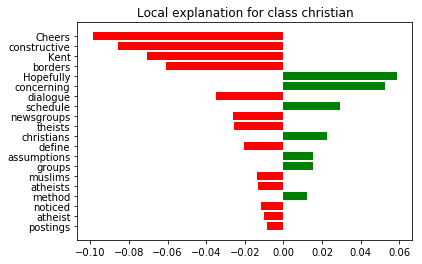

In [100]:
fig = exp.as_pyplot_figure()

In [101]:
exp.show_in_notebook(text=True)

## Observations

1. The case of words can be important when determining features with the Naive Bayes classifier, the use of proper case pronouns and titles indicates an attribution of importance, and using proper case for ordinary words like he and spirit is distinctively characteristic of the Christian class.
2. However, unexpected use of upper case such as the word COM can create a feature out of a word that might not always have this form, and so it may be worth selectively converting words like this to lower case.
3. Despite removing headers, footers and signatures there are still many repetitive uses of these elements that contribute significantly to important features - they should probably be removed.
4. It's evident that the Christian class contains many more distinctive words that are normally used that aid predictions for that class.
5. It would be good to understand the importance of words in terms of a combination of their frequencies _and_ their relative importance.
6. Examining important words after the removal of stopwords would be instructive.
7. As would experimenting with n-grams, with and without common words.
8. This is a "bag of words" approach, more sophisticated NLP techniques could be evaulated. 

## Conclusion

The default use of coef\_ in sklean Naive Bayes classifier is not suitable to derive information for both classes as it uses the second class coefficents. Additionally, the coef\_ returns frequencies of words, but does not enable a comparison of the importance of words for the classes relative to one another. 

A clearer picture of the relative frequency can be obtained by using the underlying `feature_log_prob_` values, and of the relative importance of words by subtracting `feature_log_prob_` values of one class from the other. 

Functions have been created here to make use of these properties, together with additional functions to help visualise importances.

## Utility functions

In [102]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>

<a id='cleandata_four_underscore'></a>